In [20]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

from scipy.stats import wilcoxon

from sklearnex import patch_sklearn
patch_sklearn()

Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


In [2]:
def load_bank_data(path="bank-additional.csv", sep=";"):
    df = pd.read_csv(path, sep=sep)

    if "duration" in df.columns:
        df = df.drop(columns=["duration"])
    y = (df["y"] == "yes").astype(int)
    X = df.drop(columns=["y"])
    X = pd.get_dummies(X, drop_first=True)
    return X, y, df

X, y, df_raw = load_bank_data("bank-additional.csv", sep=";")

print("Class counts:\n", df_raw["y"].value_counts())
print("X shape:", X.shape)

Class counts:
 y
no     36548
yes     4640
Name: count, dtype: int64
X shape: (41188, 52)


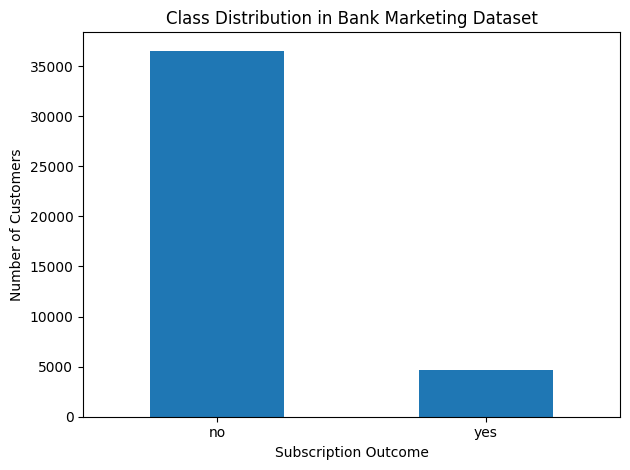

In [21]:
class_counts = df_raw["y"].value_counts()

plt.figure()
class_counts.plot(kind="bar")
plt.xlabel("Subscription Outcome")
plt.ylabel("Number of Customers")
plt.title("Class Distribution in Bank Marketing Dataset")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [4]:
COST_MODEL = {"TP": 100, "FP": -5, "FN": -100, "TN": 0}

def compute_business_value_from_cm(cm, cost_model):
    tn, fp, fn, tp = cm.ravel()
    return (tp * cost_model["TP"]
            + fp * cost_model["FP"]
            + fn * cost_model["FN"]
            + tn * cost_model["TN"])

def preds_from_threshold(y_proba, threshold):
    return (y_proba >= threshold).astype(int)

def best_threshold_on_train(y_true_train, y_proba_train, cost_model, thresholds=None):
    if thresholds is None:
        thresholds = np.linspace(0.00, 0.50, 101)

    best_t = 0.5
    best_val = -np.inf

    for t in thresholds:
        y_pred = preds_from_threshold(y_proba_train, t)
        cm = confusion_matrix(y_true_train, y_pred)
        val = compute_business_value_from_cm(cm, cost_model)
        if val > best_val:
            best_val = val
            best_t = float(t)

    return best_t, best_val

def apply_campaign_constraint_top_p(y_proba, p_contact=0.30):
    n = len(y_proba)
    k = int(np.ceil(p_contact * n))
    if k <= 0:
        return np.zeros(n, dtype=int)
    idx = np.argsort(-y_proba)
    contacted = idx[:k]
    y_pred = np.zeros(n, dtype=int)
    y_pred[contacted] = 1
    return y_pred

In [5]:
def compute_metrics(y_true, y_pred, y_proba=None, cost_model=None):
    cm = confusion_matrix(y_true, y_pred)
    out = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0),
        "BalancedAcc": balanced_accuracy_score(y_true, y_pred),
        "TN": int(cm.ravel()[0]), "FP": int(cm.ravel()[1]),
        "FN": int(cm.ravel()[2]), "TP": int(cm.ravel()[3]),
    }
    if cost_model is not None:
        out["BusinessValue"] = compute_business_value_from_cm(cm, cost_model)
    if y_proba is not None:
        out["MeanProba"] = float(np.mean(y_proba))
    return out

In [6]:
def make_pipeline(model_name, sampler_name, random_state=42):
    if sampler_name == "None":
        sampler = None
    elif sampler_name == "SMOTE":
        sampler = SMOTE(random_state=random_state)
    elif sampler_name == "Under":
        sampler = RandomUnderSampler(random_state=random_state)
    else:
        raise ValueError(f"Unknown sampler: {sampler_name}")

    if model_name == "DecisionTree":
        clf = DecisionTreeClassifier(random_state=random_state)
    elif model_name == "RandomForest":
        clf = RandomForestClassifier(random_state=random_state, n_jobs=-1)
    else:
        raise ValueError(f"Unknown model: {model_name}")

    steps = []
    if sampler is not None:
        steps.append(("sampler", sampler))
    steps.append(("clf", clf))
    return ImbPipeline(steps)


In [7]:
def bv_top_p_scorer(estimator, X_val, y_val, cost_model, p_contact):
    y_proba = estimator.predict_proba(X_val)[:, 1]
    y_pred = apply_campaign_constraint_top_p(y_proba, p_contact=p_contact)
    cm = confusion_matrix(y_val, y_pred)
    return compute_business_value_from_cm(cm, cost_model)

def hyperparam_distributions(model_name):
    if model_name == "DecisionTree":
        return {
            "clf__criterion": ["gini", "entropy"],
            "clf__max_depth": [3, 5, 7, 10, None],
            "clf__min_samples_split": [2, 5, 10, 20],
            "clf__min_samples_leaf": [1, 2, 5, 10],
            "clf__ccp_alpha": [0.0, 0.001, 0.01],
        }
    if model_name == "RandomForest":
        return {
            "clf__n_estimators": [100, 200],
            "clf__max_depth": [5, 10, 20, None],
            "clf__min_samples_split": [2, 5, 10],
            "clf__min_samples_leaf": [1, 2, 5],
            "clf__max_features": ["sqrt", "log2", None],
        }
    raise ValueError(model_name)

In [ ]:
def evaluate_model_cv(
    X, y,
    model_name="RandomForest",
    sampler_name="None",
    cost_model=COST_MODEL,
    p_contact=0.30,
    outer_splits=5,
    outer_repeats=2,
    inner_splits=3,
    n_iter=12,
    random_state=42,
    threshold_grid=None,
):
    if threshold_grid is None:
        threshold_grid = np.linspace(0.00, 0.50, 101)

    fold_results = []
    best_params_list = []

    for rep in range(outer_repeats):
        skf = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=random_state + rep)

        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y), start=1):
            X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

            pipe = make_pipeline(model_name, sampler_name, random_state=random_state)

            scorer = lambda est, Xv, yv: bv_top_p_scorer(est, Xv, yv, cost_model, p_contact)
            search = RandomizedSearchCV(
                estimator=pipe,
                param_distributions=hyperparam_distributions(model_name),
                n_iter=n_iter,
                scoring=scorer,
                cv=StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=random_state),
                n_jobs=-1,
                random_state=random_state,
                refit=True,
                verbose=0,
            )
            search.fit(X_tr, y_tr)
            best_model = search.best_estimator_
            best_params_list.append({
                "rep": rep + 1,
                "fold": fold_idx,
                "model": model_name,
                "sampler": sampler_name,
                "best_params": search.best_params_,
                "best_inner_score_bv_top_p": float(search.best_score_),
            })

            best_model.fit(X_tr, y_tr)

            proba_tr = best_model.predict_proba(X_tr)[:, 1]
            proba_val = best_model.predict_proba(X_val)[:, 1]

            best_t, _ = best_threshold_on_train(y_tr.values, proba_tr, cost_model, thresholds=threshold_grid)
            pred_val_thr = preds_from_threshold(proba_val, best_t)

            thr_metrics = compute_metrics(y_val.values, pred_val_thr, y_proba=proba_val, cost_model=cost_model)
            thr_metrics.update({
                "rep": rep + 1,
                "fold": fold_idx,
                "Model": model_name,
                "Sampler": sampler_name,
                "DecisionRule": "ThresholdOptimisedOnTrain",
                "ThresholdUsed": float(best_t),
                "p_contact": np.nan,
            })
            fold_results.append(thr_metrics)

            pred_val_top = apply_campaign_constraint_top_p(proba_val, p_contact=p_contact)
            top_metrics = compute_metrics(y_val.values, pred_val_top, y_proba=proba_val, cost_model=cost_model)
            top_metrics.update({
                "rep": rep + 1,
                "fold": fold_idx,
                "Model": model_name,
                "Sampler": sampler_name,
                "DecisionRule": f"Top{int(p_contact*100)}PctContacted",
                "ThresholdUsed": np.nan,
                "p_contact": p_contact,
            })
            fold_results.append(top_metrics)

            print(f"[rep {rep+1} fold {fold_idx}] {model_name}+{sampler_name} done. "
                  f"ThrBV={thr_metrics['BusinessValue']:.0f} TopBV={top_metrics['BusinessValue']:.0f}")

    return pd.DataFrame(fold_results), pd.DataFrame(best_params_list)

In [9]:
EXPERIMENTS = [
    ("DecisionTree", "None"),
    ("RandomForest", "None"),
    ("RandomForest", "SMOTE"),
]

all_results = []
all_best_params = []

for model_name, sampler_name in EXPERIMENTS:
    res_df, params_df = evaluate_model_cv(
        X=X, y=y,
        model_name=model_name,
        sampler_name=sampler_name,
        cost_model=COST_MODEL,
        p_contact=0.30,
        outer_splits=5,
        outer_repeats=2,
        inner_splits=3,
        n_iter=10,
        random_state=42,
        threshold_grid=np.linspace(0.00, 0.50, 101),
    )
    all_results.append(res_df)
    all_best_params.append(params_df)

results_df = pd.concat(all_results, ignore_index=True)
best_params_df = pd.concat(all_best_params, ignore_index=True)

print("\n=== Results head ===")
print(results_df.head())

print("\n=== Best params head ===")
print(best_params_df.head())

[rep 1 fold 1] DecisionTree+None done. ThrBV=56250 TopBV=25015
[rep 1 fold 2] DecisionTree+None done. ThrBV=56250 TopBV=23375
[rep 1 fold 3] DecisionTree+None done. ThrBV=56250 TopBV=29525
[rep 1 fold 4] DecisionTree+None done. ThrBV=56255 TopBV=26040
[rep 1 fold 5] DecisionTree+None done. ThrBV=56255 TopBV=25835
[rep 2 fold 1] DecisionTree+None done. ThrBV=56250 TopBV=28910
[rep 2 fold 2] DecisionTree+None done. ThrBV=56250 TopBV=23990
[rep 2 fold 3] DecisionTree+None done. ThrBV=56250 TopBV=20095
[rep 2 fold 4] DecisionTree+None done. ThrBV=56255 TopBV=23580
[rep 2 fold 5] DecisionTree+None done. ThrBV=56255 TopBV=28705
[rep 1 fold 1] RandomForest+None done. ThrBV=39425 TopBV=31780
[rep 1 fold 2] RandomForest+None done. ThrBV=54920 TopBV=27885
[rep 1 fold 3] RandomForest+None done. ThrBV=43270 TopBV=35060
[rep 1 fold 4] RandomForest+None done. ThrBV=56505 TopBV=29935
[rep 1 fold 5] RandomForest+None done. ThrBV=40145 TopBV=29525
[rep 2 fold 1] RandomForest+None done. ThrBV=57185 TopB

In [10]:
summary = (
    results_df
    .groupby(["Model", "Sampler", "DecisionRule"], as_index=False)
    .agg(
        BV_mean=("BusinessValue", "mean"),
        BV_std=("BusinessValue", "std"),
        BalAcc_mean=("BalancedAcc", "mean"),
        BalAcc_std=("BalancedAcc", "std"),
        Prec_mean=("Precision", "mean"),
        Rec_mean=("Recall", "mean"),
        F1_mean=("F1", "mean"),
    )
    .sort_values(by="BV_mean", ascending=False)
)

print("\n=== Summary (sorted by BV_mean) ===")
print(summary.to_string(index=False))


=== Summary (sorted by BV_mean) ===
       Model Sampler              DecisionRule  BV_mean      BV_std  BalAcc_mean  BalAcc_std  Prec_mean  Rec_mean  F1_mean
DecisionTree    None ThresholdOptimisedOnTrain  56252.0    2.581989     0.500000    0.000000   0.112654  1.000000 0.202496
RandomForest   SMOTE ThresholdOptimisedOnTrain  54534.0 5433.852634     0.526817    0.048553   0.121108  0.975323 0.214465
RandomForest    None ThresholdOptimisedOnTrain  44993.0 7860.793429     0.654037    0.067992   0.177803  0.848922 0.290634
RandomForest    None         Top30PctContacted  31165.0 2218.466688     0.734693    0.006573   0.269013  0.716595 0.391176
RandomForest   SMOTE         Top30PctContacted  28520.5 2198.273881     0.726860    0.006513   0.263794  0.702694 0.383588
DecisionTree    None         Top30PctContacted  25507.0 2952.126540     0.717934    0.008743   0.257848  0.686853 0.374941


In [12]:
def wilcoxon_compare(results_df, a, b, decision_rule, sampler="None"):
    A = results_df[
        (results_df["Model"] == a) &
        (results_df["Sampler"] == sampler) &
        (results_df["DecisionRule"] == decision_rule)
    ][["rep", "fold", "BusinessValue"]].rename(columns={"BusinessValue": "BV_A"})

    B = results_df[
        (results_df["Model"] == b) &
        (results_df["Sampler"] == sampler) &
        (results_df["DecisionRule"] == decision_rule)
    ][["rep", "fold", "BusinessValue"]].rename(columns={"BusinessValue": "BV_B"})

    merged = A.merge(B, on=["rep", "fold"], how="inner").sort_values(["rep", "fold"])
    if len(merged) < 5:
        raise ValueError("Not enough paired folds for Wilcoxon. Increase repeats/splits.")

    stat, p = wilcoxon(merged["BV_B"], merged["BV_A"], alternative="greater")
    return merged, float(stat), float(p)

pairs_thr, stat_thr, p_thr = wilcoxon_compare(
    results_df, a="DecisionTree", b="RandomForest",
    decision_rule="ThresholdOptimisedOnTrain",
    sampler="None"
)

pairs_top, stat_top, p_top = wilcoxon_compare(
    results_df, a="DecisionTree", b="RandomForest",
    decision_rule="Top30PctContacted",
    sampler="None"
)

print("\n=== Wilcoxon: RandomForest > DecisionTree (ThresholdOptimisedOnTrain, sampler=None) ===")
print("n_pairs:", len(pairs_thr), "stat:", stat_thr, "p:", p_thr)

print("\n=== Wilcoxon: RandomForest > DecisionTree (Top30PctContacted, sampler=None) ===")
print("n_pairs:", len(pairs_top), "stat:", stat_top, "p:", p_top)


=== Wilcoxon: RandomForest > DecisionTree (ThresholdOptimisedOnTrain, sampler=None) ===
n_pairs: 10 stat: 3.0 p: 0.9970703125

=== Wilcoxon: RandomForest > DecisionTree (Top30PctContacted, sampler=None) ===
n_pairs: 10 stat: 55.0 p: 0.0009765625


In [13]:
report_text = f"""
Statistical test (Wilcoxon signed-rank, paired folds):
H0: There is no difference in Business Value between Random Forest and Decision Tree.
H1: Random Forest achieves higher Business Value than Decision Tree.

ThresholdOptimisedOnTrain (sampler=None): Wilcoxon statistic={stat_thr:.3f}, p={p_thr:.4g}, n={len(pairs_thr)}
Top30PctContacted (sampler=None):        Wilcoxon statistic={stat_top:.3f}, p={p_top:.4g}, n={len(pairs_top)}

Interpretation: If p < 0.05, the improvement is statistically significant at the 5% level.
"""
print(report_text)


Statistical test (Wilcoxon signed-rank, paired folds):
H0: There is no difference in Business Value between Random Forest and Decision Tree.
H1: Random Forest achieves higher Business Value than Decision Tree.

ThresholdOptimisedOnTrain (sampler=None): Wilcoxon statistic=3.000, p=0.9971, n=10
Top30PctContacted (sampler=None):        Wilcoxon statistic=55.000, p=0.0009766, n=10

Interpretation: If p < 0.05, the improvement is statistically significant at the 5% level.



In [14]:
COST_MODELS = {
    "Base (FN-100, FP-5)":  {"TP": 100, "FP": -5,  "FN": -100, "TN": 0},
    "Lower FN (FN-50)":     {"TP": 100, "FP": -5,  "FN": -50,  "TN": 0},
    "Higher FP (FP-20)":    {"TP": 100, "FP": -20, "FN": -100, "TN": 0},
}

In [15]:
SENS_EXPERIMENTS = [
    ("DecisionTree", "None"),
    ("RandomForest", "None"),
]

sensitivity_rows = []

for cost_label, cost_model in COST_MODELS.items():
    for model_name, sampler_name in SENS_EXPERIMENTS:
        res_df, _ = evaluate_model_cv(
            X=X, y=y,
            model_name=model_name,
            sampler_name=sampler_name,
            cost_model=cost_model,
            p_contact=0.30,          # keep constraint fixed
            outer_splits=5,
            outer_repeats=2,
            inner_splits=3,
            n_iter=10,
            random_state=42,
            threshold_grid=np.linspace(0.00, 0.50, 101),
        )

        top = res_df[res_df["DecisionRule"] == "Top30PctContacted"]

        sensitivity_rows.append({
            "CostModel": cost_label,
            "Model": model_name,
            "BV_mean": top["BusinessValue"].mean(),
            "BV_std": top["BusinessValue"].std(),
            "BalancedAcc_mean": top["BalancedAcc"].mean(),
            "F1_mean": top["F1"].mean(),
        })

sens_summary = (
    pd.DataFrame(sensitivity_rows)
    .sort_values(["CostModel", "BV_mean"], ascending=[True, False])
)

print("\n=== Cost Sensitivity (Top30% Contacted) ===")
print(sens_summary.to_string(index=False))

[rep 1 fold 1] DecisionTree+None done. ThrBV=56250 TopBV=25015
[rep 1 fold 2] DecisionTree+None done. ThrBV=56250 TopBV=23375
[rep 1 fold 3] DecisionTree+None done. ThrBV=56250 TopBV=29525
[rep 1 fold 4] DecisionTree+None done. ThrBV=56255 TopBV=26040
[rep 1 fold 5] DecisionTree+None done. ThrBV=56255 TopBV=25835
[rep 2 fold 1] DecisionTree+None done. ThrBV=56250 TopBV=28910
[rep 2 fold 2] DecisionTree+None done. ThrBV=56250 TopBV=23990
[rep 2 fold 3] DecisionTree+None done. ThrBV=56250 TopBV=20095
[rep 2 fold 4] DecisionTree+None done. ThrBV=56255 TopBV=23580
[rep 2 fold 5] DecisionTree+None done. ThrBV=56255 TopBV=28705
[rep 1 fold 1] RandomForest+None done. ThrBV=39425 TopBV=31780
[rep 1 fold 2] RandomForest+None done. ThrBV=54920 TopBV=27885
[rep 1 fold 3] RandomForest+None done. ThrBV=43270 TopBV=35060
[rep 1 fold 4] RandomForest+None done. ThrBV=56505 TopBV=29935
[rep 1 fold 5] RandomForest+None done. ThrBV=40145 TopBV=29525
[rep 2 fold 1] RandomForest+None done. ThrBV=57185 TopB

In [16]:
for cost_label, cost_model in COST_MODELS.items():
    res_dt, _ = evaluate_model_cv(
        X, y, "DecisionTree", "None",
        cost_model=cost_model,
        p_contact=0.30,
        outer_splits=5, outer_repeats=2,
        inner_splits=3, n_iter=10,
        random_state=42
    )

    res_rf, _ = evaluate_model_cv(
        X, y, "RandomForest", "None",
        cost_model=cost_model,
        p_contact=0.30,
        outer_splits=5, outer_repeats=2,
        inner_splits=3, n_iter=10,
        random_state=42
    )

    tmp = pd.concat([res_dt, res_rf], ignore_index=True)

    pairs, stat, p = wilcoxon_compare(
        tmp,
        a="DecisionTree",
        b="RandomForest",
        decision_rule="Top30PctContacted",
        sampler="None"
    )

    print(f"{cost_label}: Wilcoxon p={p:.4g} (n={len(pairs)})")

[rep 1 fold 1] DecisionTree+None done. ThrBV=56250 TopBV=25015
[rep 1 fold 2] DecisionTree+None done. ThrBV=56250 TopBV=23375
[rep 1 fold 3] DecisionTree+None done. ThrBV=56250 TopBV=29525
[rep 1 fold 4] DecisionTree+None done. ThrBV=56255 TopBV=26040
[rep 1 fold 5] DecisionTree+None done. ThrBV=56255 TopBV=25835
[rep 2 fold 1] DecisionTree+None done. ThrBV=56250 TopBV=28910
[rep 2 fold 2] DecisionTree+None done. ThrBV=56250 TopBV=23990
[rep 2 fold 3] DecisionTree+None done. ThrBV=56250 TopBV=20095
[rep 2 fold 4] DecisionTree+None done. ThrBV=56255 TopBV=23580
[rep 2 fold 5] DecisionTree+None done. ThrBV=56255 TopBV=28705
[rep 1 fold 1] RandomForest+None done. ThrBV=39425 TopBV=31780
[rep 1 fold 2] RandomForest+None done. ThrBV=54920 TopBV=27885
[rep 1 fold 3] RandomForest+None done. ThrBV=43270 TopBV=35060
[rep 1 fold 4] RandomForest+None done. ThrBV=56505 TopBV=29935
[rep 1 fold 5] RandomForest+None done. ThrBV=40145 TopBV=29525
[rep 2 fold 1] RandomForest+None done. ThrBV=57185 TopB

In [17]:
main_table = summary[
    summary["DecisionRule"] == "Top30PctContacted"
][[
    "Model", "Sampler", "BV_mean", "BV_std",
    "BalAcc_mean", "Prec_mean", "Rec_mean", "F1_mean"
]]

print(main_table.to_string(index=False))


       Model Sampler  BV_mean      BV_std  BalAcc_mean  Prec_mean  Rec_mean  F1_mean
RandomForest    None  31165.0 2218.466688     0.734693   0.269013  0.716595 0.391176
RandomForest   SMOTE  28520.5 2198.273881     0.726860   0.263794  0.702694 0.383588
DecisionTree    None  25507.0 2952.126540     0.717934   0.257848  0.686853 0.374941


In [18]:
wilcoxon_table = pd.DataFrame([
    {
        "Decision Rule": "Threshold Optimised",
        "Wilcoxon Statistic": stat_thr,
        "p-value": p_thr,
        "Significant (α=0.05)": p_thr < 0.05
    },
    {
        "Decision Rule": "Top 30% Contacted",
        "Wilcoxon Statistic": stat_top,
        "p-value": p_top,
        "Significant (α=0.05)": p_top < 0.05
    }
])

print(wilcoxon_table.to_string(index=False))


      Decision Rule  Wilcoxon Statistic  p-value  Significant (α=0.05)
Threshold Optimised                 3.0 0.997070                 False
  Top 30% Contacted                55.0 0.000977                  True


/tmp/ipykernel_3631/2056122464.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([dt_values, rf_values], labels=["Decision Tree", "Random Forest"])


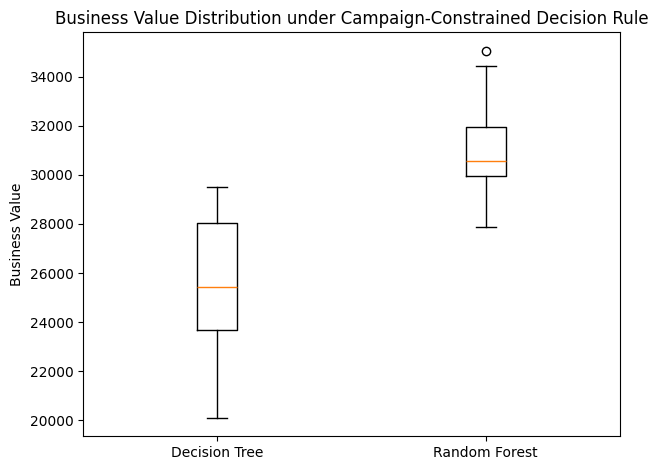

In [22]:
plot_df = results_df[
    (results_df["DecisionRule"] == "Top30PctContacted") &
    (results_df["Sampler"] == "None") &
    (results_df["Model"].isin(["DecisionTree", "RandomForest"]))
]

dt_values = plot_df[plot_df["Model"] == "DecisionTree"]["BusinessValue"]
rf_values = plot_df[plot_df["Model"] == "RandomForest"]["BusinessValue"]

plt.figure()
plt.boxplot([dt_values, rf_values], labels=["Decision Tree", "Random Forest"])
plt.ylabel("Business Value")
plt.title("Business Value Distribution under Campaign-Constrained Decision Rule")
plt.tight_layout()
plt.show()

In [23]:
results_df.to_csv("results_df.csv", index=False)
best_params_df.to_csv("best_params_df.csv", index=False)
summary.to_csv("summary.csv", index=False)
sens_summary.to_csv("sensitivity_summary.csv", index=False)